In [580]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [602]:
df = pd.read_csv('../data/train_02032024.csv',index_col=0)

In [603]:
df.drop(columns=['lat', 'lon', 'id', 'user_id','comfort_options',
       'safety_driver_assistance_options', 'performance_handling_options',
       'utility_options', 'premium_options', 'infotainment_options','top_speed'], inplace=True)

In [329]:
df.select_dtypes([np.number]).describe()

,mileage,raw_price,engine_size,registration_month,registration_year,battery_range,engine_power,seats,emissions_co2,battery_charge_time,rim_size,vehicle_height,number_of_gears,torque,gross_weight,acceleration,vehicle_width,vehicle_length,wheelbase,doors
count,8.114100e+04,81141.000000,81141.000000,81141.000000,81141.000000,1738.000000,81141.000000,81141.000000,18156.000000,779.000000,49859.000000,46821.000000,46820.000000,46790.000000,46813.000000,45572.000000,46821.000000,46821.000000,46821.000000,81141.000000
mean,1.351353e+05,15803.961388,1593.250847,5.392859,2013.471870,166.677791,136.243930,4.774923,108.247834,5.345315,16.764937,1761.044745,5.595088,212.660633,1790.090637,11.350147,1528.885457,4189.405566,2591.123086,4.536079
std,8.891535e+04,18413.672147,634.172665,3.711695,6.135108,163.016003,82.923402,0.859235,42.680757,4.037439,1.572566,79.993370,0.723975,96.576591,369.441085,2.245513,116.091698,417.432210,186.077806,0.908411
min,0.000000e+00,515.000000,0.000000,1.000000,2001.000000,2.000000,0.000000,1.000000,1.000000,1.000000,10.000000,1475.000000,1.000000,70.000000,980.000000,2.800000,1190.000000,2500.000000,1812.000000,2.000000
25%,7.900000e+04,7000.000000,1248.000000,1.000000,2008.000000,50.000000,90.000000,5.000000,96.000000,3.000000,16.000000,1722.000000,5.000000,133.000000,1570.000000,9.900000,1459.000000,3992.000000,2510.000000,5.000000
50%,1.270000e+05,11400.000000,1500.000000,5.000000,2015.000000,72.500000,115.000000,5.000000,110.000000,5.000000,17.000000,1765.000000,6.000000,205.000000,1750.000000,11.200000,1490.000000,4223.000000,2596.000000,5.000000
75%,1.800000e+05,17900.000000,1800.000000,9.000000,2018.000000,270.000000,150.000000,5.000000,127.000000,6.000000,18.000000,1810.000000,6.000000,260.000000,1940.000000,12.900000,1573.000000,4419.000000,2675.000000,5.000000
max,2.000000e+06,345000.000000,10000.000000,12.000000,2025.000000,850.000000,999.000000,11.000000,900.000000,50.000000,30.000000,2073.000000,10.000000,900.000000,3500.000000,30.500000,2950.000000,6225.000000,3750.000000,7.000000


Regarding outliers we can see some obvious values which are still in there:

- raw prices of 500 euros as we saw can be for cars being sold for spare parts. Now we saw that there is a linear relationship between a car and its mileage so these features are very correlated. That means that if we do not take into account the effect they have each other when deleting outliers that we might delete some sane data. For example we might have a car with an unusual mileage but with a price reflecting this high mileage. If we only considered the mileage then we would treat the point as an outlier. To avoid this we will remove outliers on the raw_price per km.
- engine powers of 0.
- engine sizes of 0.
- cars with 1 seat or 11 seats
- battery charge times of 50 hours
- rim sizes of 10 or 30 inches
- 10 gears or 1 gear
- torque of 900


# Outlier strategy 1 IQR:

For this strategy we will remove outliers on groups. This will be done in order to avoid removing high end cars and old cars only. The groups will be done on brand model and registration year. we will remove outliers when we have at least 20 points

In [330]:
numeric_types = df.select_dtypes(['float']).columns

<Axes: >

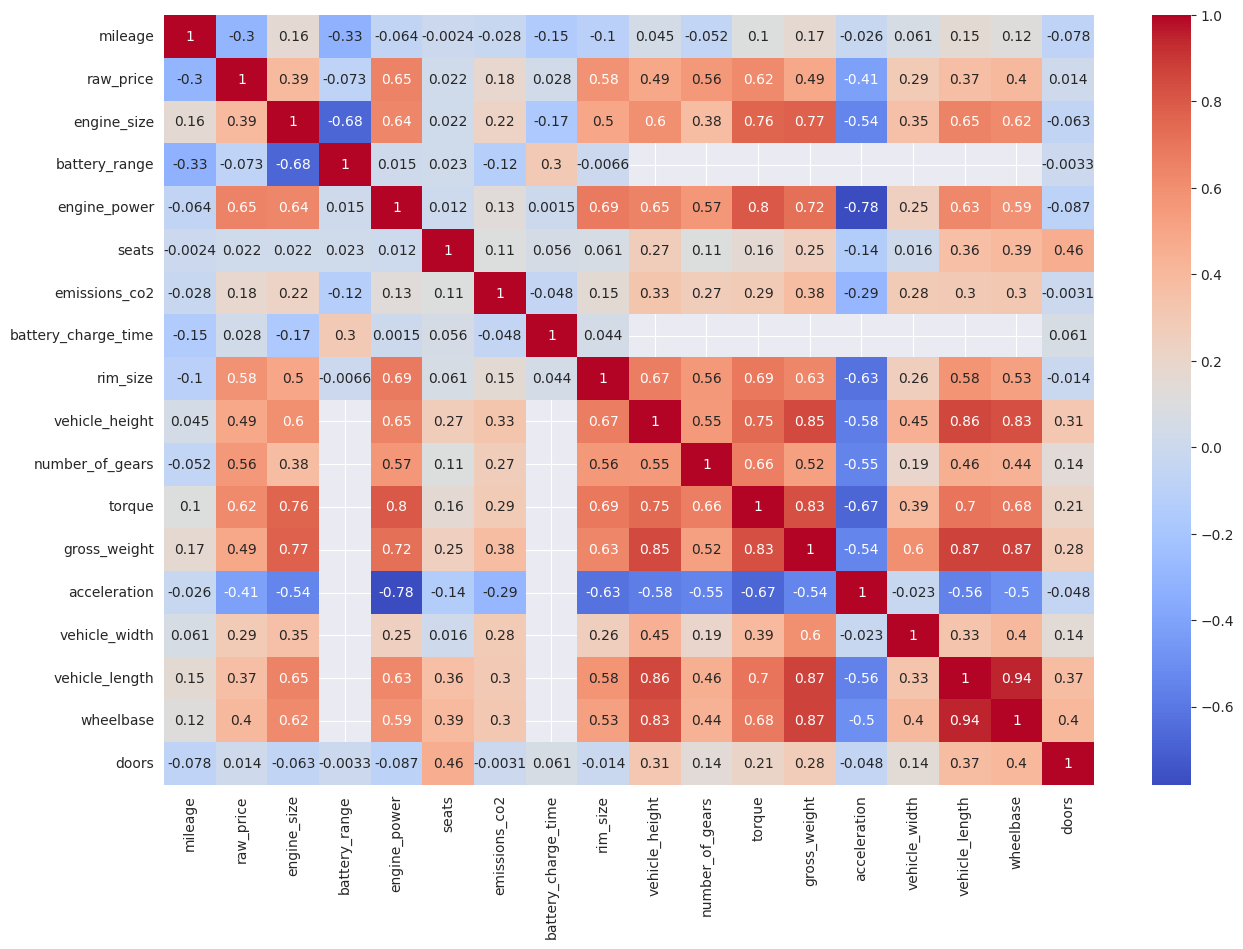

In [331]:
plt.figure(figsize=(15,10))
sns.heatmap(data = df[numeric_types].corr(), annot = True, cmap = 'coolwarm')

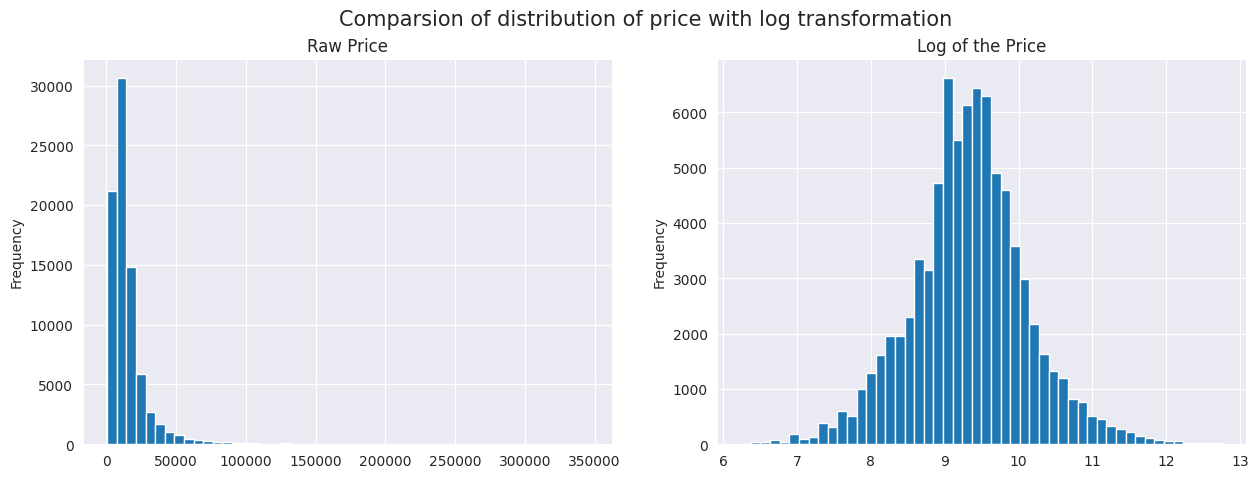

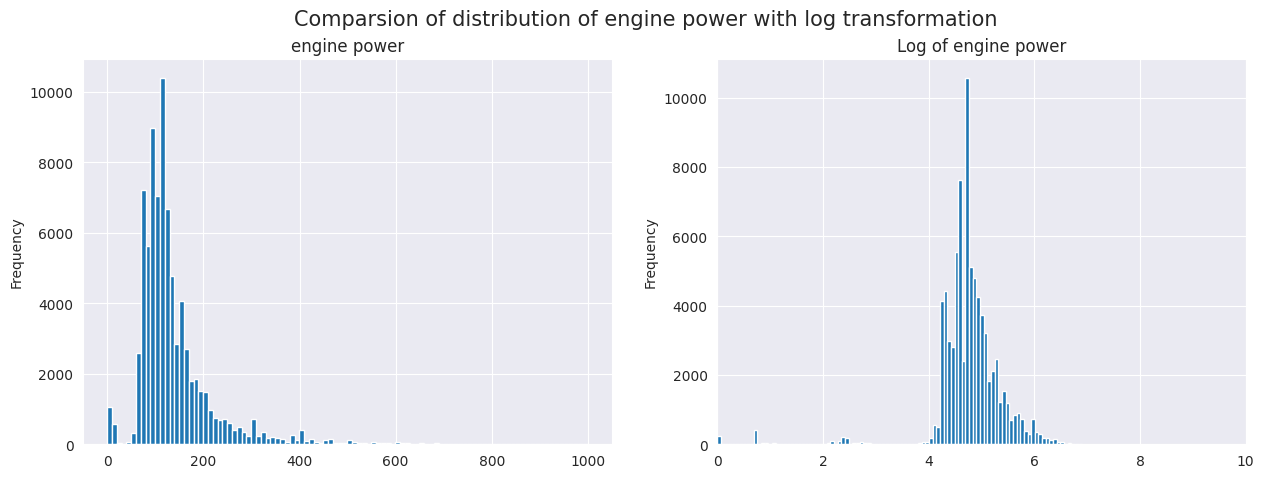

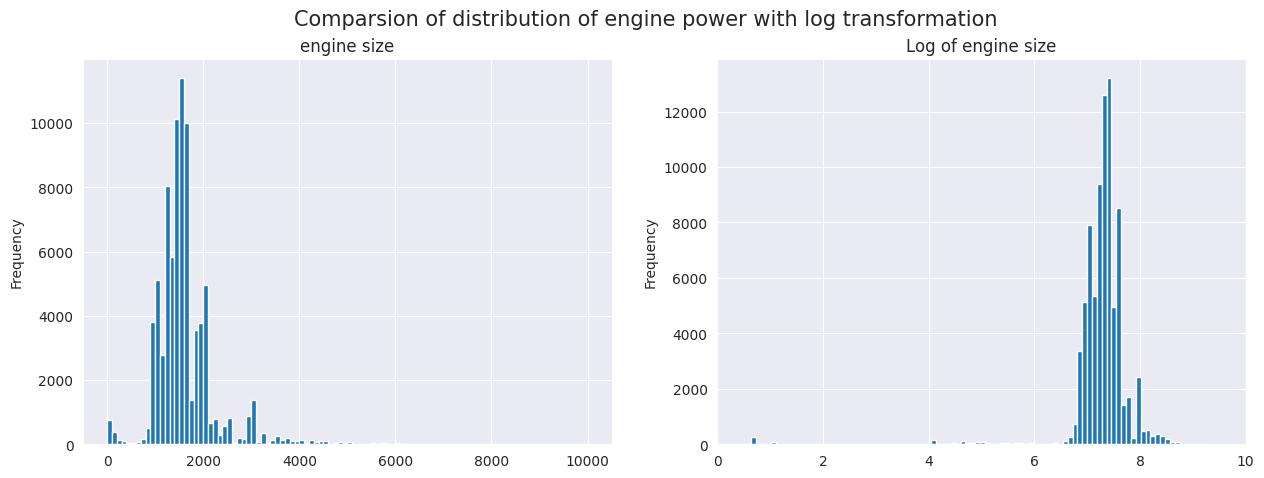

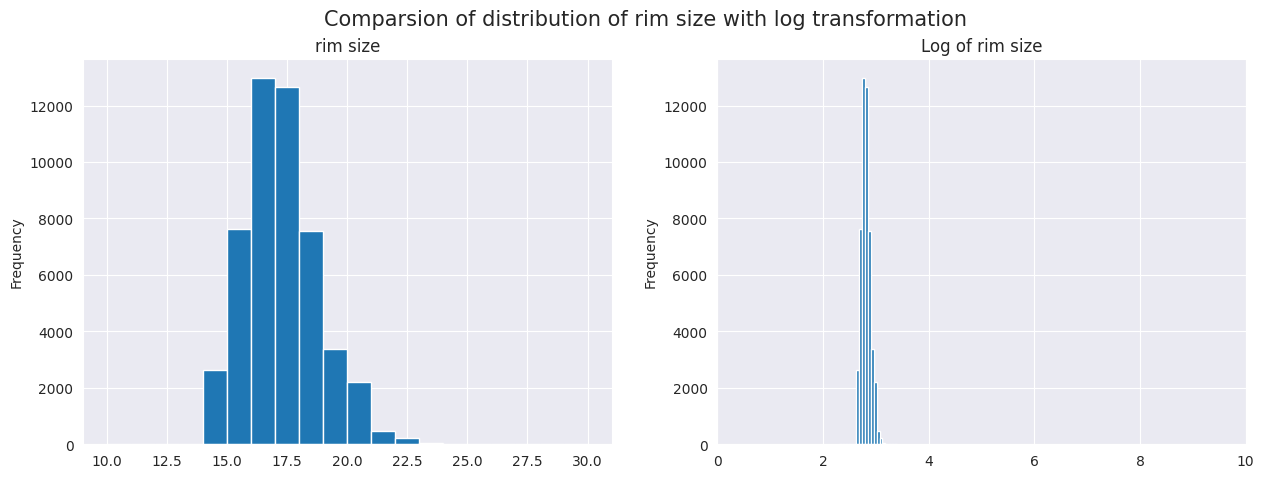

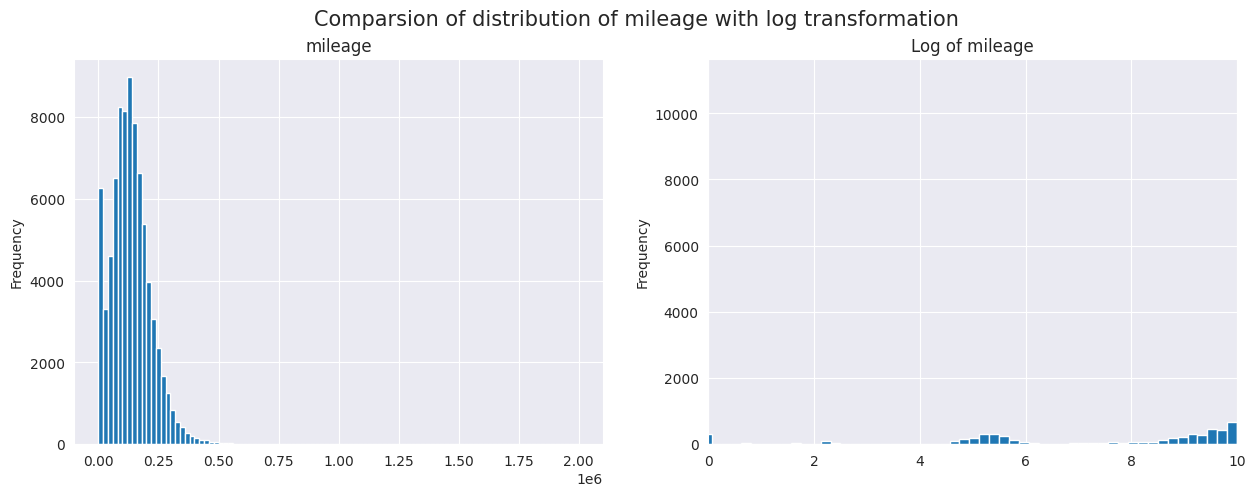

In [74]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
df.raw_price.plot(kind='hist', bins=50, ax=ax[0])
df.raw_price.apply(np.log).plot(kind='hist', bins=50, ax=ax[1])
fig.suptitle('Comparsion of distribution of price with log transformation', fontsize=15)
ax[0].set_title('Raw Price')
ax[1].set_title('Log of the Price')
fig.savefig('../plots/raw_price_dist_log_vs_no_log.png')

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
df.engine_power.plot(kind='hist', bins=100, ax=ax[0])
df.engine_power.apply(lambda x: np.log(x + 1)).plot(kind='hist', bins=100, ax=ax[1])
fig.suptitle('Comparsion of distribution of engine power with log transformation', fontsize=15)
ax[0].set_title('engine power')
ax[1].set_title('Log of engine power')
ax[1].set_xlim([0,10])
fig.savefig('../plots/engine_power_dist_log_vs_no_log.png')


fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
df.engine_size.plot(kind='hist', bins=100, ax=ax[0])
df.engine_size.apply(lambda x: np.log(x + 1)).plot(kind='hist', bins=100, ax=ax[1])
fig.suptitle('Comparsion of distribution of engine power with log transformation', fontsize=15)
ax[0].set_title('engine size')
ax[1].set_title('Log of engine size')
ax[1].set_xlim([0,10])
fig.savefig('../plots/engine_size_dist_log_vs_no_log.png')

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
df.rim_size.plot(kind='hist', bins=20, ax=ax[0])
df.rim_size.apply(lambda x: np.log(x + 1e-10)).plot(kind='hist', bins=20, ax=ax[1])
fig.suptitle('Comparsion of distribution of rim size with log transformation', fontsize=15)
ax[0].set_title('rim size')
ax[1].set_title('Log of rim size')
ax[1].set_xlim([0,10])
fig.savefig('../plots/rim_size_dist_log_vs_no_log.png')

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
df.mileage.plot(kind='hist', bins=100, ax=ax[0])
df.mileage.apply(lambda x: np.log(x + 1e-10)).plot(kind='hist', bins=200, ax=ax[1])
fig.suptitle('Comparsion of distribution of mileage with log transformation', fontsize=15)
ax[0].set_title('mileage')
ax[1].set_title('Log of mileage')
ax[1].set_xlim([0,10])
fig.savefig('../plots/mileage_dist_log_vs_no_log.png')

In [68]:
np.exp(df.engine_power.apply(lambda x: np.log(x+1e-10)).quantile(0.25) - 1.5*(df.engine_power.apply(lambda x: np.log(x+1)).quantile(0.75) - df.engine_power.apply(lambda x: np.log(x+1)).quantile(0.25)))

42.105533743302175

In [67]:
np.exp(df.engine_size.apply(lambda x: np.log(x+1e-10)).quantile(0.25) - 1.5*(df.engine_size.apply(lambda x: np.log(x+1)).quantile(0.75) - df.engine_size.apply(lambda x: np.log(x+1)).quantile(0.25)))

720.7550163188022

In [121]:
df.engine_size.quantile(0.25) - 1.5*(df.engine_size.quantile(0.75) - df.engine_size.quantile(0.25))

420.0

In [130]:
df.engine_power.quantile(0.25) - 1.5*(df.engine_power.quantile(0.75) - df.engine_power.quantile(0.25))

0.0

In [604]:
df['raw_price_log'] = df.raw_price.apply(np.log)


In [605]:
features_IQR = ['raw_price_log']

In [606]:
def IQR(df_subset, features, group_cols):
    Q1  = df_subset.groupby(group_cols)[features].quantile(0.25)
    Q3 = df_subset.groupby(group_cols)[features].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_subset = df_subset.join(lower_bound, how='left',  on=group_cols, rsuffix='_lower').copy()
    df_subset = df_subset.join(upper_bound, how='left',  on=group_cols, rsuffix='_upper').copy()
    def detect_outlier(row, feature, lower_bound, upper_bound):
        if pd.isna(row[feature]):
            return False
        else:
            return row[feature] < lower_bound or row[feature] > upper_bound

    is_outlier = pd.DataFrame(False, index=df_subset.index, columns=features)
    for feat in features:
        is_outlier[feat] = df_subset.apply(lambda row: detect_outlier(row, feat, row[f'{feat}_lower'], row[f'{feat}_upper']),axis=1)
    df_subset['is_outlier'] = is_outlier.any(axis=1)
    return df_subset

In [607]:
df['level_1'] = df.groupby(by=['brand','model','registration_year']).transform('count')['raw_price'] > 40
df['level_2'] = df.groupby(by=['brand','model']).transform('count')['raw_price'] > 40
df['level_3'] = df.groupby(by=['brand']).transform('count')['raw_price'] > 40

In [608]:
df['is_outlier'] = False
df[df.level_1] = IQR(df[df.level_1], features_IQR, ['brand','model','registration_year'])
df[df.level_2 & ~(df.level_1)] = IQR(df[df.level_2 & ~(df.level_1)], features_IQR, ['brand','model'])
df[~(df.level_1 | df.level_2) & (df.level_3)] = IQR(df[~(df.level_1 | df.level_2) & (df.level_3)], features_IQR, ['brand'])

In [609]:
df.is_outlier.sum()

2339

In [341]:
def compute_lower_bound(serie):
    return serie.quantile(0.25) - 1.5*(serie.quantile(0.75) - serie.quantile(0.25))

In [576]:
new_df['test'] = np.random.normal(size=new_df.shape[0])

In [577]:
df.merge(new_df['test'],left_index=True,right_index=True,how='left').head()

,uuid,is_new,label,model_stub,thumbs,price_debatable,title,without_vat,descriptive_title,seller,...,fuel_consumption,drive_type,doors,is_metallic,raw_price_log,level_1,level_2,level_3,is_outlier,test
93804,c504b871-9aae-4027-b641-e69704d3b3d0,False,NaN,Audi A3 '15 ΑΥΤΟΜΑΤΟ PLUG IN HYBRID ΠΡΟΣΦΟΡΑ !!!,"{'count': 63, 'urls': ['https://static.car.gr/...",True,Audi A3 '15 ΑΥΤΟΜΑΤΟ PLUG IN HYBRID ΠΡΟΣΦΟΡΑ !!!,False,Audi A3 '15 ΑΥΤΟΜΑΤΟ PLUG IN HYBRID ΠΡΟΣΦΟΡΑ !...,"{'name': 'AUTO BILIALIS', 'avatar': 'https://s...",...,NaN,FWD,5.0,False,9.825526,True,True,True,False,0.524709
76036,4fca143a-b95b-4fcd-8424-8c020262722e,False,NaN,Skoda Fabia '18 AMBITION BUSINESS,"{'count': 13, 'urls': ['https://static.car.gr/...",True,Skoda Fabia '18 AMBITION BUSINESS,False,Skoda Fabia '18 AMBITION BUSINESS - 1/2018 - 1...,"{'name': 'G & P - C A R S', 'avatar': 'https:/...",...,4.0,FWD,5.0,False,9.082507,False,True,True,False,-1.278293
90637,43dd2ca8-9d42-48bb-87d2-1159ba8afd9e,False,NaN,Toyota Corolla '01 6G/ΑΝΤΑΛΛΑΓΕΣ/ΕΤΟΙΜΟΠΑΡΑΔΟΤΟ,"{'count': 31, 'urls': ['https://static.car.gr/...",True,Toyota Corolla '01 6G/ΑΝΤΑΛΛΑΓΕΣ/ΕΤΟΙΜΟΠΑΡΑΔΟΤΟ,False,Toyota Corolla '01 6G/ΑΝΤΑΛΛΑΓΕΣ/ΕΤΟΙΜΟΠΑΡΑΔΟΤ...,"{'name': 'ΘΕΟΦΙΛΑΤΟΣ', 'avatar': None, 'verifi...",...,6.8,FWD,3.0,False,8.496990,False,True,True,False,-0.962743
24080,907ace65-f651-4363-a4fe-3aa9ba10c2c6,False,NaN,Opel Astra '16,"{'count': 19, 'urls': ['https://static.car.gr/...",True,Opel Astra '16,False,Opel Astra '16 - 8/2016 - 134.000 χλμ - Πετρέλ...,"{'classifieds_count': 1, 'name': 'Βασίλης', 'v...",...,3.7,FWD,5.0,False,9.425452,True,True,True,False,-1.045265
40206,ec2cf421-8521-45aa-81fe-c1d2db7ff076,False,NaN,Opel Astra '12 SPORT TOURER,"{'count': 19, 'urls': ['https://static.car.gr/...",True,Opel Astra '12 SPORT TOURER,False,Opel Astra '12 SPORT TOURER - 9/2012 - 202.000...,"{'name': 'Κώστας ', 'verification': {'telephon...",...,4.5,FWD,5.0,True,9.047821,True,True,True,False,-0.532247


In [578]:
new_df.head()

,uuid,is_new,label,model_stub,thumbs,price_debatable,title,without_vat,descriptive_title,seller,...,level_1,level_2,level_3,is_outlier,raw_price_log_lower,raw_price_log_upper,is_engine_outlier,is_outlier_final,outlier_isolation,test
93804,c504b871-9aae-4027-b641-e69704d3b3d0,False,NaN,Audi A3 '15 ΑΥΤΟΜΑΤΟ PLUG IN HYBRID ΠΡΟΣΦΟΡΑ !!!,"{'count': 63, 'urls': ['https://static.car.gr/...",True,Audi A3 '15 ΑΥΤΟΜΑΤΟ PLUG IN HYBRID ΠΡΟΣΦΟΡΑ !!!,False,Audi A3 '15 ΑΥΤΟΜΑΤΟ PLUG IN HYBRID ΠΡΟΣΦΟΡΑ !...,"{'name': 'AUTO BILIALIS', 'avatar': 'https://s...",...,True,True,True,False,10949.597881,25341.706884,False,False,False,0.524709
24080,907ace65-f651-4363-a4fe-3aa9ba10c2c6,False,NaN,Opel Astra '16,"{'count': 19, 'urls': ['https://static.car.gr/...",True,Opel Astra '16,False,Opel Astra '16 - 8/2016 - 134.000 χλμ - Πετρέλ...,"{'classifieds_count': 1, 'name': 'Βασίλης', 'v...",...,True,True,True,False,6885.178073,18626.933824,False,False,False,-1.045265
40206,ec2cf421-8521-45aa-81fe-c1d2db7ff076,False,NaN,Opel Astra '12 SPORT TOURER,"{'count': 19, 'urls': ['https://static.car.gr/...",True,Opel Astra '12 SPORT TOURER,False,Opel Astra '12 SPORT TOURER - 9/2012 - 202.000...,"{'name': 'Κώστας ', 'verification': {'telephon...",...,True,True,True,False,5194.982009,13646.061988,False,False,False,-0.532247
90737,e559d32e-b6e4-49fb-a1da-8950aa21ff6e,False,NaN,Nissan Micra '17,"{'count': 14, 'urls': ['https://static.car.gr/...",True,Nissan Micra '17,False,Nissan Micra '17 - 1/2017 - 98.000 χλμ - Βενζί...,"{'name': 'Δ.ΣΤΑΣΗΣ', 'avatar': None, 'verifica...",...,True,True,True,False,5271.264748,20984.910598,False,False,False,-2.092038
19809,30480d9b-1046-4fc6-b939-3dfa9d1df9d6,False,NaN,Nissan Juke '15 1461cc 110hp Diesel - Με γραμμ...,"{'count': 21, 'urls': ['https://static.car.gr/...",False,Nissan Juke '15 1461cc 110hp Diesel - Με γραμμ...,False,Nissan Juke '15 1461cc 110hp Diesel - Με γραμμ...,"{'name': 'I LINE - ΠΥΛΑΙΑ', 'avatar': 'https:/...",...,True,True,True,False,9718.147824,17016.829734,False,False,False,-1.318741


In [342]:
engine_size_lower = compute_lower_bound(df['engine_size'])
engine_power_lower = np.exp(compute_lower_bound(df['engine_power'].apply(lambda x: np.log(x+1e-10))))

In [343]:
engine_power_lower

41.82822013911445

In [344]:
engine_size_lower

420.0

In [345]:
df['is_engine_outlier'] = (df.engine_power < engine_power_lower) | (df.engine_size < engine_size_lower)

In [346]:
df['is_outlier_final'] = df.is_outlier | df.is_engine_outlier

In [347]:
df['raw_price_log_upper'] = np.exp(df['raw_price_log_upper'])
df['raw_price_log_lower'] = np.exp(df['raw_price_log_lower'])

In [348]:
cols = ['brand','model','registration_year','raw_price_log_lower','raw_price','raw_price_log_upper','engine_power','engine_size', 'level_1','level_2','level_3','is_engine_outlier', 'is_outlier','is_outlier_final']

In [349]:
df[df.is_outlier_final].shape[0]

5155

In [350]:
df[df.is_outlier_final].shape[0]/df.shape[0]

0.06353138364082277

In [351]:
df.loc[df.is_outlier_final,cols].head(20)

,brand,model,registration_year,raw_price_log_lower,raw_price,raw_price_log_upper,engine_power,engine_size,level_1,level_2,level_3,is_engine_outlier,is_outlier,is_outlier_final
74839,volkswagen,polo,2015,6236.005725,2400.0,14353.538396,90.0,1422.0,True,True,True,False,True,True
70947,peugeot,2008,2019,10521.098552,25000.0,18458.196075,120.0,1499.0,True,True,True,False,True,True
86249,skoda,octavia,2005,2018.961516,3800.0,11210.036542,12.0,1600.0,True,True,True,True,False,True
83334,renault,clio,2014,5365.673920,4550.0,14174.995192,75.0,1461.0,True,True,True,False,True,True
54634,nissan,juke,2017,10213.765968,12190.0,18889.605650,116.0,1.0,True,True,True,True,False,True
97615,toyota,yaris,2025,19497.736991,66670.0,29178.901512,280.0,1618.0,True,True,True,False,True,True
18906,audi,a3,2019,13311.079104,23000.0,21381.437055,116.0,1600.0,True,True,True,False,True,True
92818,opel,corsa,2011,4094.458102,3000.0,9437.146269,85.0,1248.0,True,True,True,False,True,True
56252,opel,astra,2004,1313.207861,800.0,9421.931399,1.0,1400.0,True,True,True,True,True,True
60157,opel,corsa,2008,2653.147063,10300.0,10855.033405,390.0,1.0,True,True,True,True,False,True


In [352]:
df[df.is_outlier_final].raw_price.describe()

count      5155.000000
mean      15398.287876
std       19709.274648
min         515.000000
25%        3700.000000
50%        9000.000000
75%       19980.000000
max      310000.000000
Name: raw_price, dtype: float64

In [18]:
df.groupby(['brand','model','registration_year']).transform('count')['id']

,uuid,is_new,label,model_stub,thumbs,price_debatable,title,without_vat,descriptive_title,seller,...,acceleration,vehicle_width,body_type,vehicle_length,trim,wheelbase,fuel_consumption,drive_type,doors,is_metallic
93804,69,69,0,69,69,69,69,69,69,69,...,42,42,42,42,42,42,49,64,69,69
76036,10,10,0,10,10,10,10,10,10,10,...,9,9,9,9,9,9,9,10,10,10
90637,29,29,0,29,28,29,29,29,29,29,...,20,20,20,20,20,20,21,23,29,29
24080,163,163,0,163,159,163,163,163,163,163,...,156,156,156,156,156,156,158,159,163,163
40206,84,84,0,84,83,84,84,84,84,84,...,49,49,49,49,49,49,58,72,84,84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,9,9,0,9,9,9,9,9,9,9,...,0,0,0,0,0,0,2,8,9,9
54886,19,19,0,19,19,19,19,19,19,19,...,16,16,16,16,16,16,16,19,19,19
76820,53,53,0,53,53,53,53,53,53,53,...,50,50,50,50,50,50,51,52,53,53
860,1,1,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,1,1,1


# Method 2 Isolation Forest

In [218]:
from sklearn.ensemble import IsolationForest


In [543]:
df_isolation =new_df.copy()

In [544]:
df_isolation.select_dtypes(include=[np.number]).columns

Index(['mileage', 'raw_price', 'engine_size', 'registration_month',
       'registration_year', 'battery_range', 'engine_power', 'seats',
       'emissions_co2', 'battery_charge_time', 'rim_size', 'vehicle_height',
       'number_of_gears', 'torque', 'gross_weight', 'acceleration',
       'vehicle_width', 'vehicle_length', 'wheelbase', 'doors',
       'raw_price_log', 'raw_price_log_lower', 'raw_price_log_upper'],
      dtype='object')

In [546]:
df_isolation = df_isolation[['brand','model','registration_year','mileage', 'engine_size','engine_power', 'raw_price','fuel_type','drive_type','gearbox_type']].copy()

In [547]:
df_isolation.shape

(81141, 10)

In [548]:
df_isolation['car_group'] = df_isolation['brand'] + '_' + df_isolation['model']

In [549]:

dummies_group = pd.get_dummies(df_isolation.car_group)
dummies_drive = pd.get_dummies(df_isolation.drive_type)
dummies_gearbox = pd.get_dummies(df_isolation.gearbox_type)
dummies_fuel = pd.get_dummies(df_isolation.fuel_type)

df_isolation = pd.concat([df_isolation,dummies_group, dummies_drive, dummies_gearbox, dummies_fuel], axis=1).drop(columns=['brand','model','car_group', 'drive_type', 'gearbox_type', 'fuel_type'])

In [570]:
if_model = IsolationForest(n_jobs=-1, n_estimators=500,max_features= 175, contamination=0.06 )

In [571]:
if_model.fit(df_isolation)

IsolationForest(contamination=0.06, max_features=175, n_estimators=500,
                n_jobs=-1)

In [572]:
outliers = if_model.predict(df_isolation)

In [573]:
new_df['outlier_isolation'] = [True if x==-1 else False for x in outliers]

In [574]:
new_df.loc[new_df.outlier_isolation, ['brand','model','registration_year','mileage', 'engine_size','engine_power', 'seats', 'raw_price']].head(20)

,brand,model,registration_year,mileage,engine_size,engine_power,seats,raw_price
71968,smart,fortwo,2009,158000.0,1000.0,71.0,2.0,5990.0
97615,toyota,yaris,2025,0.0,1618.0,280.0,4.0,66670.0
63831,smart,fortwo,2007,217000.0,700.0,61.0,2.0,3900.0
80053,audi,a4,2003,410000.0,1600.0,115.0,5.0,3999.0
74169,smart,fortwo,2017,16410.0,1000.0,71.0,2.0,16200.0
88934,volkswagen,golf,2016,89800.0,86.0,115.0,5.0,11990.0
70363,peugeot,3008,2020,69505.0,1500.0,300.0,5.0,25900.0
10632,smart,fortwo,2008,208000.0,800.0,70.0,2.0,5500.0
50030,skoda,octavia,2004,269.0,1800.0,400.0,5.0,9500.0
11180,peugeot,208,2024,3500.0,1200.0,100.0,5.0,27500.0


In [414]:
df[(df.outlier_isolation==-1)&(df.model=='x3')].head(20)

AttributeError: 'DataFrame' object has no attribute 'outlier_isolation'

In [415]:
new_df.is_outlier_final.sum()

5155

In [416]:
new_df[new_df.outlier_isolation & new_df.is_outlier_final].shape[0]/new_df.is_outlier_final.sum()

0.1478176527643065

In [417]:
new_df[new_df.outlier_isolation & new_df.is_outlier_final].shape[0]/new_df.outlier_isolation.sum()

0.1878235149124969

In [364]:
new_df.is_outlier_final.sum()/new_df.outlier_isolation.sum()

1.2706433325117081